<h1 style="text-align: center; font-size: 2.3em; color: navy; font-family: Arial, sans-serif; font-weight: bold;">
Astrophysical Techniques – Homework 1 
</h1>

<h2 style="text-align: center; font-size: 2em; color: black; font-family: Arial, sans-serif;">
Estimation the Effect of Atmospheric Extinction
</h2>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif;">
Master in Astrophysics and Space Science (MASS)-(2024/2025) <br>
Department of Astronomy, University of Belgrade <br>
Instructor: Prof. Dragana Ilić
</p>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif; font-style: italic;">
Report by Nandita Das
</p>

## **Introduction**

This exercise focuses on measuring **atmospheric extinction** using standard stars observed at different airmasses. Starlight dims as it travels through Earth's atmosphere — the more air it passes through, the fainter it looks.

To correct for this effect, we use the **Beer–Lambert law**, which relates instrumental magnitude to airmass:

**_m₍ᵢₙₛₜ₎ = m₀ + k × X_**

Where:  
- *m₍ᵢₙₛₜ₎* = observed (instrumental) magnitude  
- *m₀* = magnitude above the atmosphere  
- *k* = extinction coefficient  
- *X* = airmass

We plot *m₍ᵢₙₛₜ₎* vs. *X* and estimate the slope *k*. This gives the extinction correction we apply to all further photometry.

## **Import Libraries**

In [2]:
# import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time
from scipy.optimize import curve_fit

In [31]:
### Let's write down our data

# List of star names, each repeated 4 times (one for each observation)
stars = ['HR7235', 'HR7235', 'HR7235', 'HR7235', 
        'HR7298', 'HR7298', 'HR7298', 'HR7298', 
        'HR7377', 'HR7377', 'HR7377', 'HR7377', 
        'HR7387', 'HR7387', 'HR7387', 'HR7387',
        'HR7405', 'HR7405', 'HR7405', 'HR7405', 
        'HR7478', 'HR7478', 'HR7478', 'HR7478']

# Measured photon counts in the V filter for each observation
N_Vs = [1.49e7, 1.42e7, 1.32e7, 1.05e7,
        4.65e6, 4.33e6, 3.21e6, 3.61e6,
        1.04e7, 9.60e6, 8.33e6, 6.91e6,
        3.24e6, 2.82e6, 2.38e6, 1.91e6,
        3.92e6, 3.81e6, 3.45e6, 2.56e6,
        3.12e6, 3.12e6, 2.96e6, 2.38e6]

# Measured photon counts in the B filter for each observation
N_Bs = [4.90e7, 4.37e7, 4.03e7, 2.74e7,
        1.94e7, 1.79e7, 1.11e7, 1.24e7,
        2.82e7, 2.40e7, 1.97e7, 1.45e7,
        7.42e6, 5.67e6, 4.53e6, 3.01e6,
        4.37e6, 4.17e6, 3.58e6, 2.23e6,
        5.47e6, 5.52e6, 4.96e6, 3.42e6]

# Local Sidereal Time (LST) at which each observation was made
LSTs = ['19 29.6', '22 18.6', '23 10.2', '00 09.4',
        '19 32.8', '22 22.0', '23 13.6', '01 15.2',
        '19 36.0', '22 25.6', '23 17.1', '00 02.1',
        '19 39.5', '22 29.1', '23 21.0', '00 05.9',
        '19 43.1', '22 32.8', '23 24.4', '01 19.0',
        '19 46.9', '22 36.7', '23 28.7', '01 23.1']

# Create the initial DataFrame
df = pd.DataFrame({'star': stars, 'N_V': N_Vs, 'N_B': N_Bs, 'LST': LSTs})

# Display the first few rows
df.head()

,star,N_V,N_B,LST
0,HR7235,14900000.0,49000000.0,19 29.6
1,HR7235,14200000.0,43700000.0,22 18.6
2,HR7235,13200000.0,40300000.0,23 10.2
3,HR7235,10500000.0,27400000.0,00 09.4
4,HR7298,4650000.0,19400000.0,19 32.8


In [32]:
simbad = Simbad()  # Create a Simbad query object

# Add B and V magnitudes to the query result using VOTable fields
simbad.add_votable_fields("flux(B)", "flux(V)")

/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_59936/308915671.py:4: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")
/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_59936/308915671.py:4: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")


In [33]:
# Query SIMBAD for each star in the DataFrame and store the result tables in a list
simbad_tables = [simbad.query_object(star) for star in df['star']]

In [34]:
# Extract RA, DEC, B, and V magnitudes from each SIMBAD result table
RAs, DECs, Vs, Bs = [], [], [], []

for star_table in simbad_tables:
    RA_HA = star_table['ra'][0]     # Right Ascension in HMS string format
    DEC_DMS = star_table['dec'][0]  # Declination in DMS string format
    V = star_table['V'][0]          # V magnitude
    B = star_table['B'][0]          # B magnitude

    RAs.append(RA_HA)
    DECs.append(DEC_DMS)
    Vs.append(V)
    Bs.append(B)

# Add the extracted values as new columns to the DataFrame
df['RA_HA'] = RAs
df['DEC_DMS'] = DECs
df['V'] = Vs
df['B'] = Bs

df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243


In [35]:
# Convert RA (HMS) and DEC (DMS) string values to decimal degrees
RAs_deg, DECs_deg = [], []

for index, row in df.iterrows():
    ra_HA = row['RA_HA']        # Right Ascension as HMS string (e.g., '19 29.6')
    dec_DMS = row['DEC_DMS']    # Declination as DMS string (e.g., '+45 12 30')
    
    # Use SkyCoord for coordinate conversion
    coord = SkyCoord(ra_HA, dec_DMS, unit=(u.hourangle, u.deg))
    
    # Append converted decimal degree values
    RAs_deg.append(coord.ra.deg)
    DECs_deg.append(coord.dec.deg)

# Store decimal values in the DataFrame
df['ra_DEG'] = RAs_deg
df['dec_DEG'] = DECs_deg

df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966


In [36]:
# Define Toronto observatory latitude in degrees and convert to radians
observatory_lat_deg = 43 + (52 / 60)  # 43 degrees 52 minutes
observatory_lat_rad = np.radians(observatory_lat_deg)

# Function to calculate cos(Z) based on LST, RA, and DEC
def calculate_cos_Z(LST_HA, RA_deg, DEC_deg):
    # Convert LST string (e.g., "10 30") to degrees
    LST_deg = Angle(LST_HA, unit=u.hourangle).degree
    hour_angle_deg = LST_deg - RA_deg
    hour_angle_rad = np.radians(hour_angle_deg)
    DEC_rad = np.radians(DEC_deg)

    # cos(Z) formula: projection of the star altitude angle
    cos_Z = np.sin(observatory_lat_rad) * np.sin(DEC_rad) + \
            np.cos(observatory_lat_rad) * np.cos(DEC_rad) * np.cos(hour_angle_rad)
    return cos_Z

# Calculate cos(Z) for each star and store in a new column
cos_Zs = []
for index, row in df.iterrows():
    cos_Z = calculate_cos_Z(row['LST'], row['ra_DEG'], row['dec_DEG'])
    cos_Zs.append(cos_Z)

df['cos_Z'] = cos_Zs
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281


In [37]:
# Convert cos(Z) values to airmass using an empirical correction formula

def cosZ_to_airmass(cos_Z):
    if cos_Z > 0:
        # Apply airmass formula with refraction correction
        airmass = (1 / cos_Z) * (1 - 0.0012 * ((1 / cos_Z**2) - 1))
    else:
        # Invalid geometry (star below horizon)
        airmass = np.inf
    return airmass

# Apply to the whole DataFrame and store as a new column 'X'
df['X'] = df['cos_Z'].apply(cosZ_to_airmass)
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633


In [38]:
# Calculating instrument magnitudes

def return_instrument_mag(N_photons):
    return -2.5 * np.log10(N_photons)

df['V_ins'] = df['N_V'].apply(return_instrument_mag)
df['B_ins'] = df['N_B'].apply(return_instrument_mag)

In [39]:
# Fitting for gamma and beta with Scipy curve_fit

df['V-V_ins'] = df['V'] - df['V_ins']
df['B_ins-V_ins'] = df['B_ins'] - df['V_ins']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['V-V_ins'].to_numpy())
gamma, beta = params[0], params[1]

print('Gamma:\t', gamma)
print('Beta:\t', beta)

Gamma:	 -0.11787693721908288
Beta:	 20.687034303169842


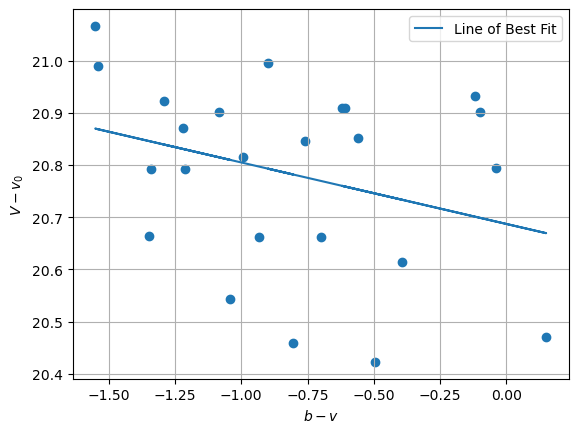

In [42]:
# Plot the transformation relation between instrumental and standard magnitudes

# Scatter plot: instrumental color index (b - v) vs difference (V - v₀)
plt.scatter(df['B_ins-V_ins'].to_numpy(), df['V-V_ins'].to_numpy())

# Plot the best-fit line using gamma (slope) and beta (intercept)
plt.plot(df['B_ins-V_ins'].to_numpy(),
         df['B_ins-V_ins'].to_numpy() * gamma + beta,
        label='Line of Best Fit')

plt.xlabel('$b-v$')          # Instrumental color index
plt.ylabel('$V-v_0$')        # Difference between standard and instrumental V magnitudes
plt.legend()
plt.grid()

In [44]:
# Doing the same for eta and epsilon

df['B-V'] = df['B'] - df['V']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['B-V'].to_numpy())
epsilon, eta = params[0], params[1]

print('Epsilon:\t', epsilon)
print('Eta:\t\t', eta)

Epsilon:	 1.1602652408347853
Eta:		 1.4818180804431966


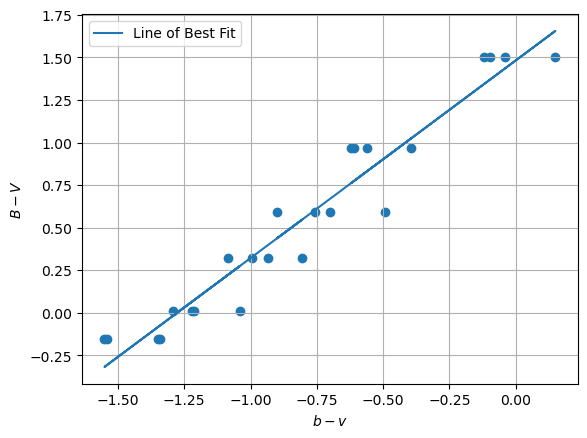

In [ ]:
# Plot the transformation from instrumental to standard color index

# Scatter plot: instrumental color (b - v) vs. standard color index (B - V)
plt.scatter(df['B_ins-V_ins'].to_numpy(), df['B-V'].to_numpy())

# Plot best-fit transformation line using epsilon (slope) and eta (intercept)
plt.plot(df['B_ins-V_ins'].to_numpy(),
         df['B_ins-V_ins'].to_numpy() * epsilon + eta,
        label='Line of Best Fit')

plt.xlabel('$b-v$')     # Instrumental color index
plt.ylabel('$B-V$')     # Standard color index
plt.grid()
plt.legend()

In [47]:
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925,-17.932966,-19.225490,20.922966,-1.292525,0.010
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333,-17.880721,-19.101204,20.870721,-1.220483,0.010
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888,-17.801435,-19.013263,20.791435,-1.211828,0.010
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925,-17.552973,-18.594376,20.542973,-1.041403,0.010
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633,-16.668632,-18.219504,21.066632,-1.550872,-0.155


In [48]:
# Populating observed reference star magnitudes using the instrumental magnitudes

def return_V_obs(Bins_minus_Vins, V_ins):
    return beta + gamma * Bins_minus_Vins + V_ins

df['V_obs'] = df.apply(lambda row: return_V_obs(row['B_ins-V_ins'], row['V_ins']), axis=1)
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V,V_obs
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925,-17.932966,-19.225490,20.922966,-1.292525,0.010,2.906427
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333,-17.880721,-19.101204,20.870721,-1.220483,0.010,2.950180
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888,-17.801435,-19.013263,20.791435,-1.211828,0.010,3.028446
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925,-17.552973,-18.594376,20.542973,-1.041403,0.010,3.256818
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633,-16.668632,-18.219504,21.066632,-1.550872,-0.155,4.201214


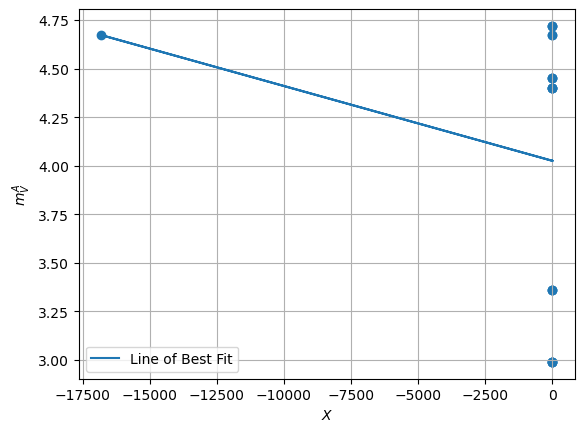

In [49]:
# Fitting to find k_V (cleaned for NaN/inf)

# Remove invalid values
valid = np.isfinite(df['X']) & np.isfinite(df['V'])
X_clean = df['X'][valid].to_numpy()
V_clean = df['V'][valid].to_numpy()

# Fit the linear model
params, _ = curve_fit(linear_fit, X_clean, V_clean)
k_V, m = params[0], params[1]

# Plot
plt.scatter(X_clean, V_clean)
plt.plot(X_clean, X_clean * k_V + m, label='Line of Best Fit')

plt.xlabel('$X$')
plt.ylabel('$m_V^A$')
plt.grid()
plt.legend()

In [50]:
target_V_estimate = gamma * (return_instrument_mag(7.7E5) - return_instrument_mag(3.56E5)) + beta + return_instrument_mag(3.56E5)

print('The estimated true V magnitude of our star is {:.3f}'.format(target_V_estimate))

The estimated true V magnitude of our star is 6.907


In [51]:
# Let's check the target star around its coordinates.

target_table = simbad.query_region(SkyCoord(ra='19h34.1m', dec='+31d18m'), radius=100 * u.arcsec)
target_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,B,V
,deg,deg,mas,mas,deg,,,,
object,float64,float64,float32,float32,int16,str1,object,float64,float64
Gaia DR3 2044818055433168768,293.5217321563908,31.30481721274166,0.0786,0.0908,90,O,2020yCat.1350....0G,--,--


The target star does not have UBV mags, but does have Gaia magnitudes. The G-band Gaia magnitude is around 18, which is very far away.